In [1]:
from dateutil.parser import parse
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
%matplotlib inline

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

## 1: Raw Data Import and Oil Price Treatment

In [2]:
brent_monthly = pd.read_csv('OIL PRICES/data/brent-monthly_csv.csv')
eu_economy = pd.read_csv('EU27 Economy/namq_10_gdp__custom_1561076_page_linear.csv')
brent_monthly

,Date,Price
0,1987-05-15,18.58
1,1987-06-15,18.86
2,1987-07-15,19.86
3,1987-08-15,18.98
4,1987-09-15,18.31
...,...,...
409,2021-06-15,73.16
410,2021-07-15,75.17
411,2021-08-15,70.75
412,2021-09-15,74.49


In [3]:
brent_monthly['Date'] = pd.to_datetime(brent_monthly['Date'])
brent_quarterly = brent_monthly.groupby(pd.PeriodIndex(brent_monthly['Date'], freq='Q')).Price.mean()
brent_quarterly = brent_quarterly.to_frame(name='brent_price_dollars')
brent_quarterly

,brent_price_dollars
Date,
1987Q2,18.720000
1987Q3,19.050000
1987Q4,17.863333
1988Q1,15.736667
1988Q2,16.150000
...,...
2020Q4,44.290000
2021Q1,60.820000
2021Q2,68.833333


## 2: EU 27 GDP Cleaning

In [4]:
eu_gdp_market_price = eu_economy[eu_economy['na_item'] == 'B1GQ']
eu_gdp_market_price = eu_gdp_market_price[['TIME_PERIOD', 'OBS_VALUE']]
eu_gdp_market_price.rename(columns={'TIME_PERIOD':'Date', 'OBS_VALUE' : 'eu_gdp_market_price'}, inplace=True)
eu_gdp_market_price.Date = pd.to_datetime(eu_gdp_market_price.Date)
eu_gdp_market_price.Date = pd.PeriodIndex(eu_gdp_market_price['Date'], freq='Q')
eu_gdp_market_price.set_index(['Date'], inplace=True)
eu_gdp_market_price

,eu_gdp_market_price
Date,
1995Q1,1552295.9
1995Q2,1570766.1
1995Q3,1598116.8
1995Q4,1617041.7
1996Q1,1634559.7
...,...
2020Q2,3079094.8
2020Q3,3421167.8
2020Q4,3440453.9


#### Intermediate Dataset to combine Brent & EU GDP, on which further columns will be joined:

In [5]:
eu_gdp_and_brent = eu_gdp_market_price.join(brent_quarterly, how='left', sort=True)
eu_gdp_and_brent['gdp_billion_euros'] = eu_gdp_and_brent.eu_gdp_market_price / 1000
eu_gdp_and_brent.drop(['eu_gdp_market_price'], axis=1, inplace=True)
eu_gdp_and_brent

,brent_price_dollars,gdp_billion_euros
Date,,
1995Q1,16.890000,1552.2959
1995Q2,18.103333,1570.7661
1995Q3,16.216667,1598.1168
1995Q4,16.966667,1617.0417
1996Q1,18.566667,1634.5597
...,...,...
2020Q2,29.343333,3079.0948
2020Q3,42.963333,3421.1678
2020Q4,44.290000,3440.4539


## 3: Gross Capital Formation Treatment & Cleaning

In [6]:
gross_cap_formation = eu_economy[eu_economy['na_item'] == 'P5G']
gross_cap_formation = gross_cap_formation[['TIME_PERIOD', 'OBS_VALUE']]
gross_cap_formation.rename(columns={'TIME_PERIOD':'Date', 'OBS_VALUE' : 'gross_cap_formation'}, inplace=True)
gross_cap_formation.Date = pd.to_datetime(gross_cap_formation.Date)
gross_cap_formation.Date = pd.PeriodIndex(gross_cap_formation['Date'], freq='Q')
gross_cap_formation.set_index(['Date'], inplace=True)
gross_cap_formation

,gross_cap_formation
Date,
1995Q1,345151.6
1995Q2,348219.5
1995Q3,358927.8
1995Q4,360411.1
1996Q1,354820.6
...,...
2020Q2,660968.7
2020Q3,711445.7
2020Q4,756038.7


## 4: Wages & Salaries Treatment & Cleaning

In [7]:
wages_and_sal = eu_economy[eu_economy['na_item'] == 'D11']
wages_and_sal = wages_and_sal[['TIME_PERIOD', 'OBS_VALUE']]
wages_and_sal.rename(columns={'TIME_PERIOD':'Date', 'OBS_VALUE' : 'wages_and_sal'}, inplace=True)
wages_and_sal.Date = pd.to_datetime(wages_and_sal.Date)
wages_and_sal.Date = pd.PeriodIndex(wages_and_sal['Date'], freq='Q')
wages_and_sal.set_index(['Date'], inplace=True)
wages_and_sal

,wages_and_sal
Date,
1995Q1,587900.5
1995Q2,595459.0
1995Q3,602559.6
1995Q4,613284.0
1996Q1,616699.0
...,...
2020Q2,1216970.8
2020Q3,1308421.2
2020Q4,1320361.5


## XX: Joining of all parts to make the Main DataFrame

In [8]:
DATA = eu_gdp_and_brent.join(gross_cap_formation, how='left', sort=True)
DATA = DATA.join(wages_and_sal, how='left', sort=True)
DATA

,brent_price_dollars,gdp_billion_euros,gross_cap_formation,wages_and_sal
Date,,,,
1995Q1,16.890000,1552.2959,345151.6,587900.5
1995Q2,18.103333,1570.7661,348219.5,595459.0
1995Q3,16.216667,1598.1168,358927.8,602559.6
1995Q4,16.966667,1617.0417,360411.1,613284.0
1996Q1,18.566667,1634.5597,354820.6,616699.0
...,...,...,...,...
2020Q2,29.343333,3079.0948,660968.7,1216970.8
2020Q3,42.963333,3421.1678,711445.7,1308421.2
2020Q4,44.290000,3440.4539,756038.7,1320361.5


Converting Quarter PeriodIndex format back to timestamps for analysis : 

In [9]:
DATA['newdate'] = DATA.index.to_timestamp()
DATA.set_index(['newdate'], inplace=True)
DATA

,brent_price_dollars,gdp_billion_euros,gross_cap_formation,wages_and_sal
newdate,,,,
1995-01-01,16.890000,1552.2959,345151.6,587900.5
1995-04-01,18.103333,1570.7661,348219.5,595459.0
1995-07-01,16.216667,1598.1168,358927.8,602559.6
1995-10-01,16.966667,1617.0417,360411.1,613284.0
1996-01-01,18.566667,1634.5597,354820.6,616699.0
...,...,...,...,...
2020-04-01,29.343333,3079.0948,660968.7,1216970.8
2020-07-01,42.963333,3421.1678,711445.7,1308421.2
2020-10-01,44.290000,3440.4539,756038.7,1320361.5


## Visualizing the Time Series

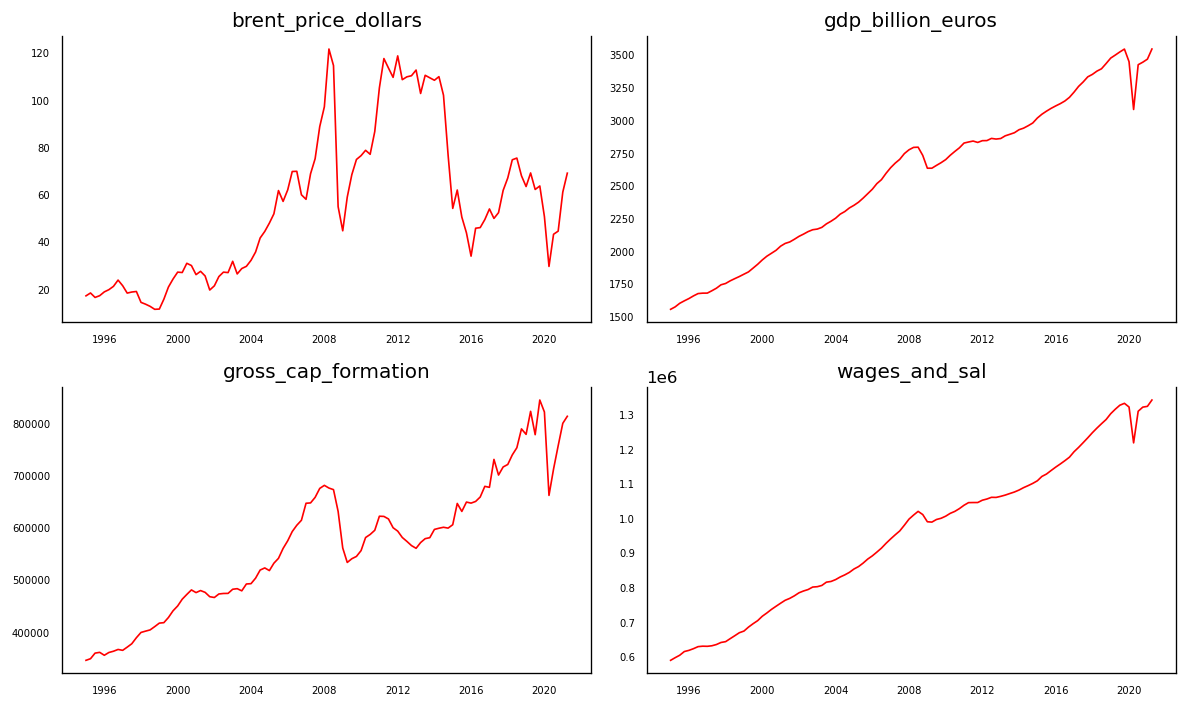

In [10]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(10,6)) 
for i, ax in enumerate(axes.flatten()):
    data = DATA[DATA.columns[i]]
    ax.plot(data, color='red', linewidth=1) # Decorations
    ax.set_title(DATA.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6, width=3)
    
plt.tight_layout();

## Granger's Causality Test

In [11]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=1
test ='ssr_chi2test'
def grangers_causation_matrix(df, variables, test='ssr_chi2test', verbose=False):
    
    """
    Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table
    are the P-Values. P-Values lesser than the significance level (0.05), implies
    the Null Hypothesis that the coefficients of the corresponding past values is
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(df[[r, c]], maxlag=maxlag, verbose=False)
            p_values =[round(test_result[i+1][0][test][1],4) for i in range(maxlag)] 
            if verbose:
                print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c]= min_p_value
    df.columns =[var +'_x'for var in variables]
    df.index =[var +'_y'for var in variables]
    return df

grangers_causation_matrix(DATA, variables = ['brent_price_dollars', 'gdp_billion_euros', 'gross_cap_formation',
       'wages_and_sal'])

ValueError: Insufficient observations. Maximum allowable lag is 0

C:\Users\Vlad\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'
